## Plot the clustering results test 1

1. we compare the 2pt measurements from cubic and cutsky, and we should find consistent clustering
2. We plot separately the impact of redshift errros on the cubic and cutsky mocks

In [2]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table,join,Column

from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction, setup_logging
from pycorr.corrfunc import CorrfuncTwoPointCounter
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pycorr import project_to_multipoles, project_to_wp, TwoPointCorrelationFunction, setup_logging
setup_logging(level='warning')

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_BIN_OVERALL, REDSHIFT_BIN_LSS, REDSHIFT_ABACUSHF_v1, NRAN, TRACER_CUTSKY_INFO
from helper import GET_REPEATS_DV, GET_CTHR, GET_REPEATS_NUMBER
from cat_tools import read_positions_weights
from fitting_tools import load_bins
from plotting_tools import COLOR_OVERALL

%load_ext autoreload
%autoreload 2
%matplotlib inline


BASE_DIR = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'
RESULT_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results'

def zfmt(x):
    return f"{x:.3f}".replace(".", "p")

cosmo = DESI()
rmin, rmax, rbin, lenr = load_bins('xi')
kmin, kmax, kbin, lenk = load_bins('pk')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [20]:
REDSHIFT_ABACUSHF_v1['LRG'][:1]

[0.5]

## First, compare with the Box and Cutsky measurements

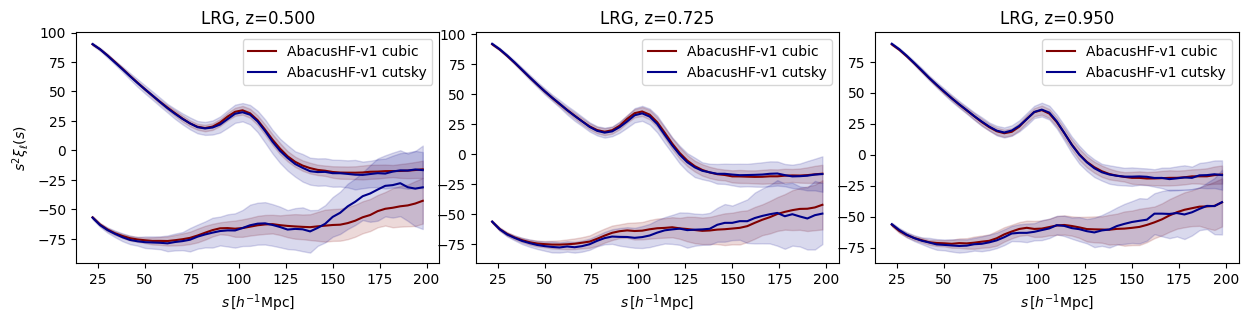

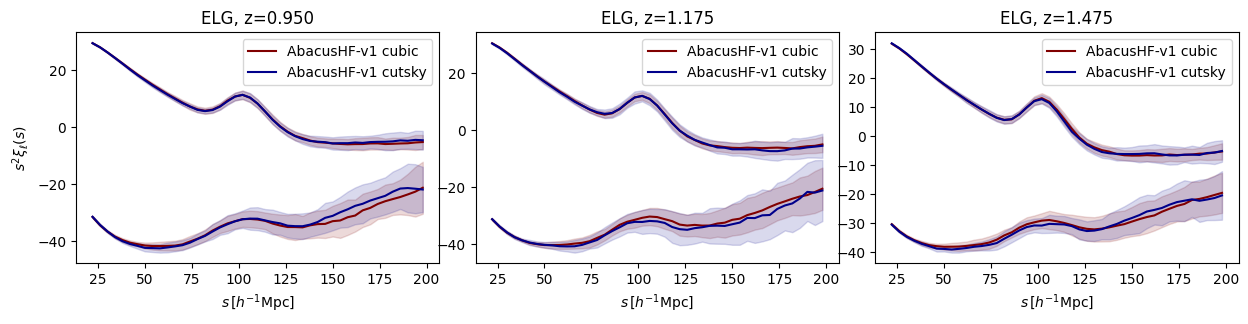

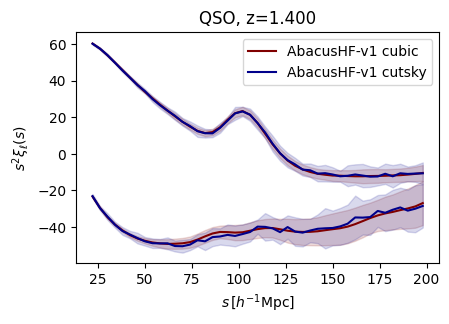

In [100]:
# for two point correlation function

corr = 'xi'

tracers = ['LRG', 'ELG', 'QSO']
# tracers = ['QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 3))
    gs = gridspec.GridSpec(1, 3, wspace=0.1, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['maroon', 'darkblue']
        for ind_in, domain in enumerate(['cubic', 'cutsky']):
            if domain == 'cubic':
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
            elif domain == 'cutsky':
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
                # suffix = '_bin'
                # fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            r        = np.array(tab_fid['r'])
            for ell in [0,2]:
                xi_ell_mean = np.array(tab_fid[f'xi{ell}_mean'])
                xi_ell_std   = np.array(tab_fid[f'xi{ell}_std'])
                if ell == 0:
                    label = f'AbacusHF-v1 {domain}'
                else:
                    label = None
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.fill_between(r, r**2*(xi_ell_mean-xi_ell_std),r**2*(xi_ell_mean+xi_ell_std), color=colors[ind_in], alpha=0.15)
                ax.plot(r, r**2*xi_ell_mean, color=colors[ind_in], label=label, alpha=1.0)
                if indz == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                ax.legend()
                # ax.grid(alpha=0.3)

# Box clustering

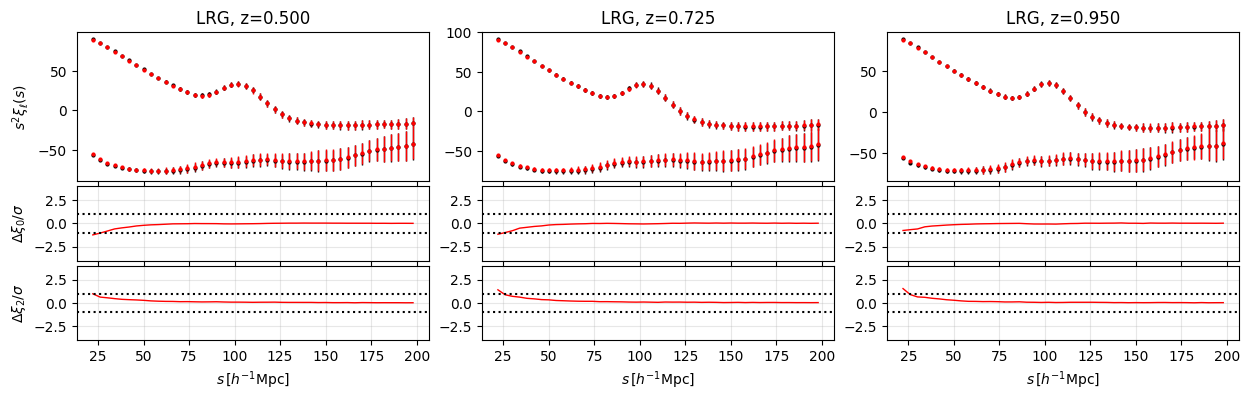

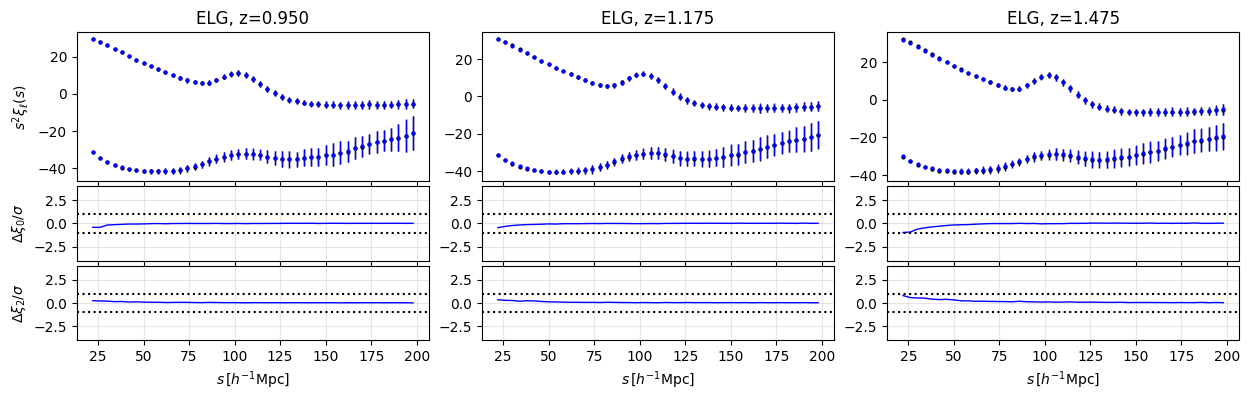

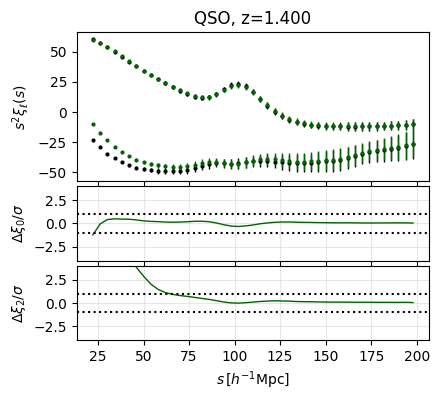

In [ ]:
# for two point correlation function

corr = 'xi'
# rcut = [60, 160]
rcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.15, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer]]
        clean_mean = {}
        clean_std  = {}
        for inde, zerr in enumerate([False, True]):
            fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
            if zerr == True: fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            r        = np.array(tab_fid['r'])
            if rcut is not None:
                mask = (r>rcut[0])&(r < rcut[1])
                tab_fid = tab_fid[mask]
                r = r[mask]
            for ell in [0,2]:
                xi_ell_mean = np.array(tab_fid[f'xi{ell}_mean'])
                xi_ell_std   = np.array(tab_fid[f'xi{ell}_std'])
                if not zerr:
                    # store clean multipole for this ell
                    clean_mean[ell] = xi_ell_mean.copy()
                    clean_std[ell]  = xi_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.errorbar(r, r**2 * xi_ell_mean, yerr=r**2 * xi_ell_std, 
                            fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                if indz == 0 and ell == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_2/\sigma$")
                    err = np.sqrt(xi_ell_std**2 + clean_std[ell]**2)
                    ax.plot(r, (xi_ell_mean - clean_mean[ell])/err, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    ax.set_ylim([-4,4])
                    ax.grid(alpha=0.3)

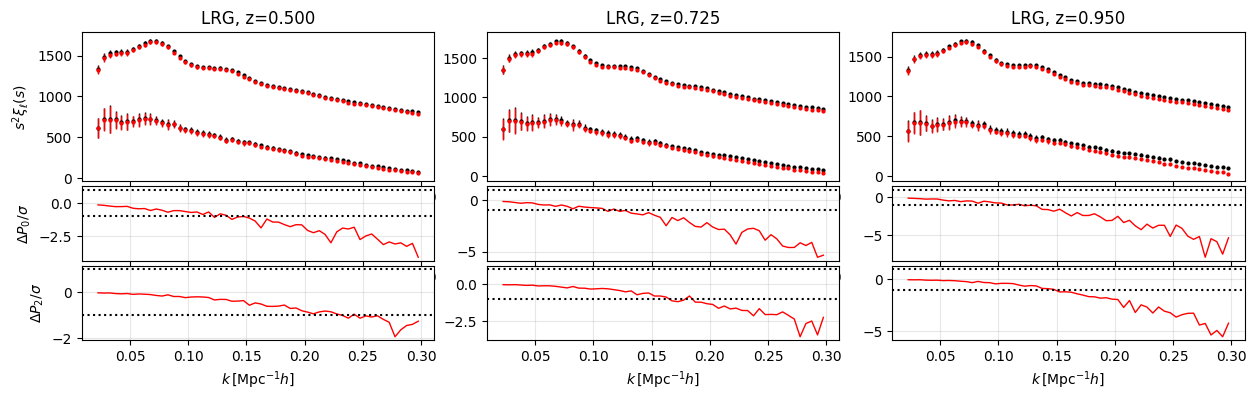

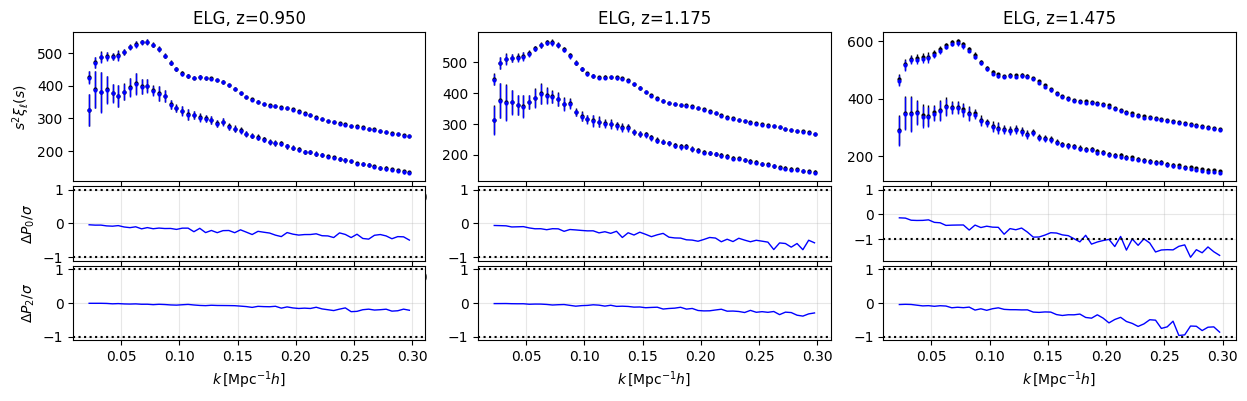

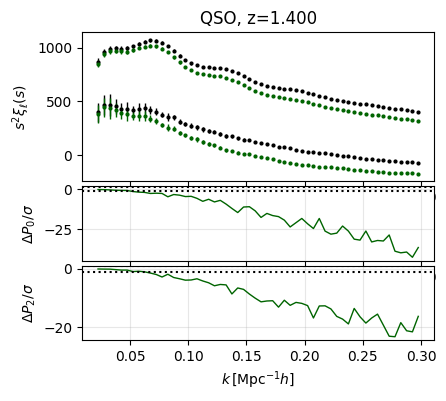

In [ ]:
# for power spectrum
corr = 'pk'
# kcut = [0.02, 0.2]
kcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.15, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer]]
        clean_mean = {}
        clean_std  = {}
        for inde, zerr in enumerate([False, True]):
            fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'
            if zerr == True: fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}_zobs{z1:.1f}-{z2:.1f}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            k       = np.array(tab_fid['k'])
            if kcut is not None:
                mask = (k>kcut[0])&(k < kcut[1])
                tab_fid = tab_fid[mask]
                k = k[mask]
            for ell in [0,2]:
                pk_ell_mean = np.array(tab_fid[f'pk{ell}_mean'])
                pk_ell_std   = np.array(tab_fid[f'pk{ell}_std'])
                if zerr is False:
                    clean_mean[ell] = pk_ell_mean.copy()
                    clean_std[ell] = pk_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.errorbar(k, k * pk_ell_mean, yerr=k * pk_ell_std, 
                            fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                if indz == 0 and ell == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta P_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$k\,[\mathrm{Mpc} ^{-1}h]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta P_2/\sigma$")
                    err = np.sqrt(pk_ell_std**2+clean_std[ell]**2)
                    ax.plot(k, (pk_ell_mean-clean_mean[ell])/err, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    # ax.set_ylim([-10,10])
                    ax.grid(alpha=0.3)

# Cutsky clustering

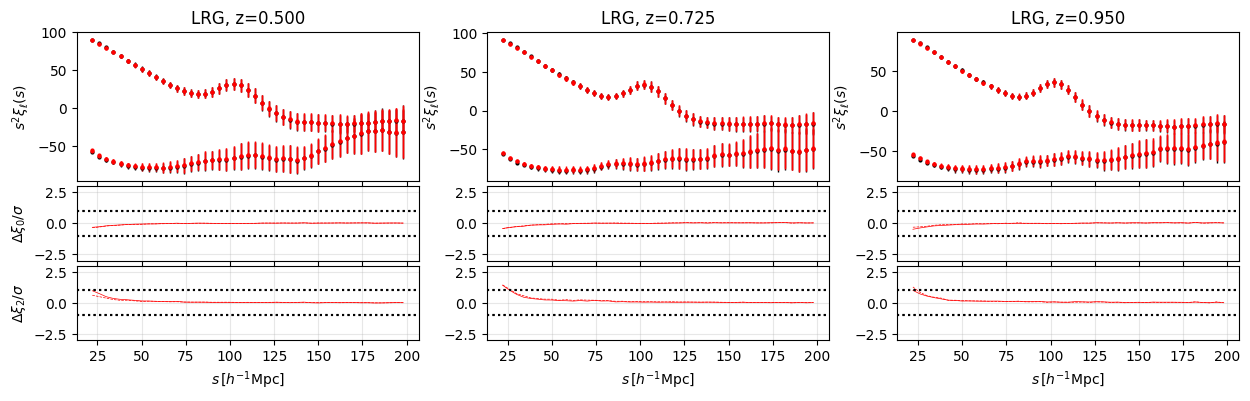

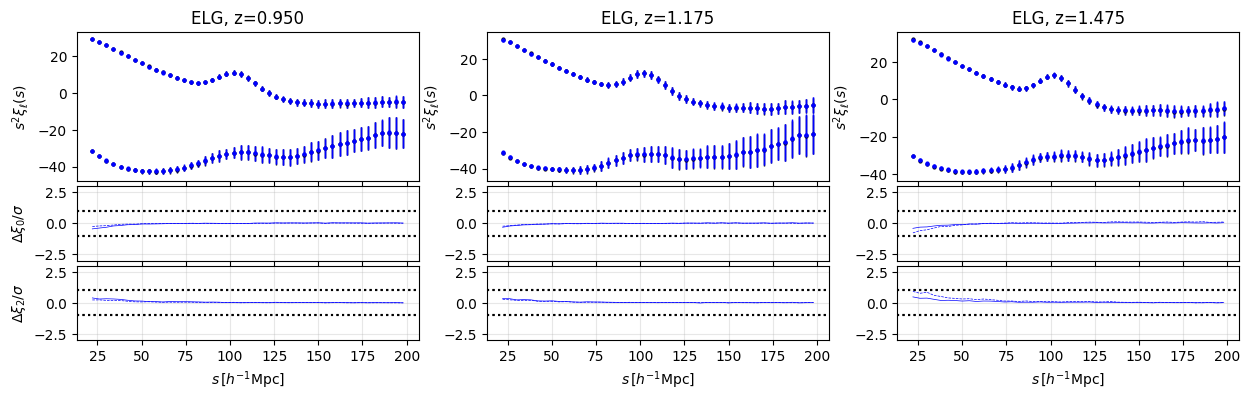

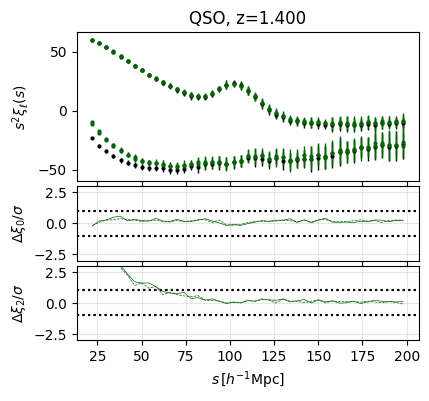

In [104]:
# for two point correlation function

corr = 'xi'
domain = 'cutsky'
# rcut = [60, 160]
rcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.2, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        clean_mean = {}
        clean_std  = {}
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer], COLOR_OVERALL[tracer]]
        lss = ['-', '-', '--']
        for inde, zerr in enumerate([False, 'global', 'bin']):
            fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
            if zerr is not False:
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}_{zerr}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            r        = np.array(tab_fid['r'])
            if rcut is not None:
                mask = (r>rcut[0])&(r < rcut[1])
                tab_fid = tab_fid[mask]
                r = r[mask]
            for ell in [0,2]:
                xi_ell_mean = np.array(tab_fid[f'xi{ell}_mean'])
                xi_ell_std   = np.array(tab_fid[f'xi{ell}_std'])
                if not zerr:
                    # store clean multipole for this ell
                    clean_mean[ell] = xi_ell_mean.copy()
                    clean_std[ell]  = xi_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                # ax.errorbar(r, r**2 * xi_ell_mean, yerr=r**2 * xi_ell_std, 
                            # fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                ax.errorbar(r, r**2 * xi_ell_mean, yerr=r**2 * xi_ell_std, 
                            fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                if inde == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_2/\sigma$")
                    err = np.sqrt(xi_ell_std**2 + clean_std[ell]**2)
                    ax.plot(r, (xi_ell_mean - clean_mean[ell])/err, 
                            ls=lss[inde], lw=0.5, color=colors[inde])  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    ax.set_ylim([-3,3])
                    ax.grid(alpha=0.3)

## APPENDIX

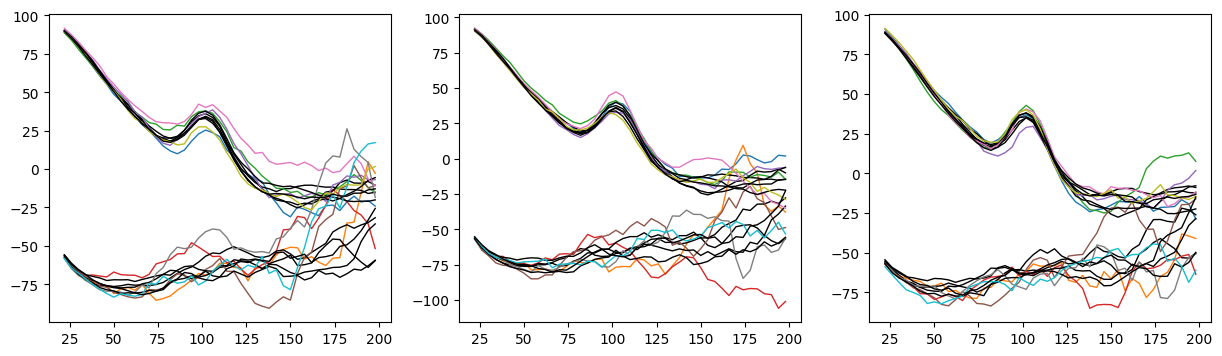

In [127]:
# for two point correlation function

corr = 'xi'

# tracers = ['LRG', 'ELG', 'QSO']
tracers = ['LRG']
for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(1, 3, wspace=0.2, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        ax = plt.subplot(gs[indz])
        for mock_id in range(5):
            mock_id03 =  f"{mock_id:03}"
            domain = 'cutsky'
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            ax.plot(r, r**2*xi[0], lw = 1)
            ax.plot(r, r**2*xi[1], lw = 1)

            domain = 'cubic'
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            ax.plot(r, r**2*xi[0], lw = 1, color = 'black')
            ax.plot(r, r**2*xi[1], lw = 1, color = 'black')

[0.02268204 0.02764907 0.03262953 0.03761292 0.04260007 0.04758946
 0.05258336 0.05757627 0.06256912 0.06756442 0.0725575  0.07755483
 0.08255304 0.08754968 0.09254586 0.09754292 0.10254236 0.10753957
 0.11253686 0.11753562 0.1225342  0.12753216 0.13253095 0.13752957
 0.14252756 0.14752836 0.15252884 0.15752723 0.16252556 0.16752447
 0.1725248  0.1775251  0.18252275 0.18752124 0.19252154 0.19752145
 0.20252079 0.20752038 0.21251983 0.21751936 0.22251928 0.22751907
 0.23251854 0.23751816 0.24251752 0.24751682 0.25251706 0.25751612
 0.26251633 0.26751619 0.27251474 0.27751502 0.2825152  0.28751456
 0.29251382 0.29751407]
[0.02268204 0.02764907 0.03262953 0.03761292 0.04260007 0.04758946
 0.05258336 0.05757627 0.06256912 0.06756442 0.0725575  0.07755483
 0.08255304 0.08754968 0.09254586 0.09754292 0.10254236 0.10753957
 0.11253686 0.11753562 0.1225342  0.12753216 0.13253095 0.13752957
 0.14252756 0.14752836 0.15252884 0.15752723 0.16252556 0.16752447
 0.1725248  0.1775251  0.18252275 0.18

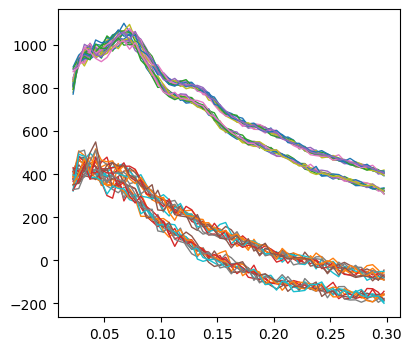

In [9]:
# for two point correlation function

corr = 'pk'
domain = 'cutsky'

tracers = ['QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(1, 3, wspace=0.2, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        ax = plt.subplot(gs[indz])
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        for mock_id in range(12):
            zerr = None
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic:':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
                if zerr is not None:
                    fn = cutsky_dir + f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}_{zerr}.npy'
            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            ax.plot(k, k*pk[0], lw = 1)
            ax.plot(k, k*pk[1], lw = 1)

            zerr = 'global'
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic:':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
                if zerr is not None:
                    fn = cutsky_dir + f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}_{zerr}.npy'
            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            ax.plot(k, k*pk[0], lw = 1)
            ax.plot(k, k*pk[1], lw = 1)
            print(k)


            # zerr = 'bin'
            # mock_id03 =  f"{mock_id:03}"
            # if domain == 'cubic:':
            #     cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
            #     fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            # elif domain == 'cutsky':
            #     cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
            #     fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            #     if zerr is not None:
            #         fn = cutsky_dir + f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}_{zerr}.npy'
            # result = PowerSpectrumMultipoles.load(fn)
            # result = result.select((kmin,kmax,kbin))
            # pk = np.real(result.get_power())
            # k = result.kavg
            # ax.plot(k, k*pk[0], lw = 1)
            # ax.plot(k, k*pk[1], lw = 1)

            # (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
            # fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}.npy'
            # result = TwoPointCorrelationFunction.load(fn)
            # result = result[::rbin,::]
            # result.select((rmin, rmax))
            # r, xi = project_to_multipoles(result, ells=[0,2])
            # ax.plot(r, r**2*xi[0], lw = 1)
            # ax.plot(r, r**2*xi[1], lw = 1)

In [92]:
# save the results
corr = 'xi'

domain = 'cubic'

# tracers = ['QSO']
tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):

        xi0_all = []
        xi2_all = []

        # out_fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'

        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            xi0_all.append(xi[0])
            xi2_all.append(xi[1])
        xi0_all = np.array(xi0_all)
        xi2_all = np.array(xi2_all)
        xi0_mean = xi0_all.mean(axis=0)
        xi0_std  = xi0_all.std(axis=0, ddof=1)
        xi2_mean = xi2_all.mean(axis=0)
        xi2_std  = xi2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'r': r,
                'xi0_mean': xi0_mean,
                'xi0_std':  xi0_std,
                'xi2_mean': xi2_mean,
                'xi2_std':  xi2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")


        continue
        suffix = '_global'
        xi0_all = []
        xi2_all = []
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            xi0_all.append(xi[0])
            xi2_all.append(xi[1])

        xi0_all = np.array(xi0_all)
        xi2_all = np.array(xi2_all)

        xi0_mean = xi0_all.mean(axis=0)
        xi0_std  = xi0_all.std(axis=0, ddof=1)
        xi2_mean = xi2_all.mean(axis=0)
        xi2_std  = xi2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'r': r,
                'xi0_mean': xi0_mean,
                'xi0_std':  xi0_std,
                'xi2_mean': xi2_mean,
                'xi2_std':  xi2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")


        suffix = '_bin'
        xi0_all = []
        xi2_all = []
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            xi0_all.append(xi[0])
            xi2_all.append(xi[1])

        xi0_all = np.array(xi0_all)
        xi2_all = np.array(xi2_all)

        xi0_mean = xi0_all.mean(axis=0)
        xi0_std  = xi0_all.std(axis=0, ddof=1)
        xi2_mean = xi2_all.mean(axis=0)
        xi2_std  = xi2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'r': r,
                'xi0_mean': xi0_mean,
                'xi0_std':  xi0_std,
                'xi2_mean': xi2_mean,
                'xi2_std':  xi2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")

Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_LRG_z0.500_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_LRG_z0.725_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_LRG_z0.950_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_ELG_z0.950_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_ELG_z1.175_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_ELG_z1.475_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_QSO_z1.400_DR2_v1.0_r20-200.csv


In [ ]:
# save the pk results
corr = 'pk'
domain = 'cubic'

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):

        pk0_all = []
        pk2_all = []
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'

        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'

            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            pk0_all.append(pk[0])
            pk2_all.append(pk[1])
        pk0_all = np.array(pk0_all)
        pk2_all = np.array(pk2_all)
        pk0_mean = pk0_all.mean(axis=0)
        pk0_std  = pk0_all.std(axis=0, ddof=1)
        pk2_mean = pk2_all.mean(axis=0)
        pk2_std  = pk2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'k': k,
                'pk0_mean': pk0_mean,
                'pk0_std':  pk0_std,
                'pk2_mean': pk2_mean,
                'pk2_std':  pk2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")

        # save the redshift errors contaminated pk
        pk0_all = []
        pk2_all = []

        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}_zobs{z1:.1f}-{z2:.1f}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}.npy'
            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            pk0_all.append(pk[0])
            pk2_all.append(pk[1])
        pk0_all = np.array(pk0_all)
        pk2_all = np.array(pk2_all)
        pk0_mean = pk0_all.mean(axis=0)
        pk0_std  = pk0_all.std(axis=0, ddof=1)
        pk2_mean = pk2_all.mean(axis=0)
        pk2_std  = pk2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'k': k,
                'pk0_mean': pk0_mean,
                'pk0_std':  pk0_std,
                'pk2_mean': pk2_mean,
                'pk2_std':  pk2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")

Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_LRG_z0.500_DR2_v1.0_k0.02-0.3.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_LRG_z0.500_DR2_v1.0_k0.02-0.3_zobs0.4-0.6.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_LRG_z0.725_DR2_v1.0_k0.02-0.3.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_LRG_z0.725_DR2_v1.0_k0.02-0.3_zobs0.6-0.8.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_LRG_z0.950_DR2_v1.0_k0.02-0.3.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_LRG_z0.950_DR2_v1.0_k0.02-0.3_zobs0.8-1.1.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cubic_ELG_z0.950_DR2_v1.0_k0.02-0.3.csv
Saved stats to /glo